In [1]:
# pip install tensorflow==2.11.1

In [2]:
import json
import warnings
warnings.filterwarnings("ignore")

# File paths
file1 = "renttherunway_final_data.json"

# Function to read JSON lines data from a file
def read_json_lines(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))  # Load each JSON object per line
    return data

# Load data from each file
renttherunway_data = read_json_lines(file1)

# Display the data (printing just the first entry for readability)
print("Rent the Runway Data Sample:", renttherunway_data[0])

Rent the Runway Data Sample: {'fit': 'fit', 'user_id': '420272', 'bust size': '34d', 'item_id': '2260466', 'weight': '137lbs', 'rating': '10', 'rented for': 'vacation', 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.", 'body type': 'hourglass', 'review_summary': 'So many compliments!', 'category': 'romper', 'height': '5\' 8"', 'size': 14, 'age': '28', 'review_date': 'April 20, 2016'}


In [3]:
len(renttherunway_data)

192544

In [4]:
import pandas as pd

renttherunway_df = pd.read_json(file1, lines=True)
renttherunway_df.describe()

,user_id,item_id,rating,size,age
count,192544.000000,1.925440e+05,192462.000000,192544.000000,191584.000000
mean,499494.100149,1.045684e+06,9.092371,12.245175,33.871017
std,289059.719328,8.053148e+05,1.430044,8.494877,8.058083
min,9.000000,1.233730e+05,2.000000,0.000000,0.000000
25%,250654.250000,1.950760e+05,8.000000,8.000000,29.000000
50%,499419.000000,9.483960e+05,10.000000,12.000000,32.000000
75%,750974.000000,1.678888e+06,10.000000,16.000000,37.000000
max,999997.000000,2.966087e+06,10.000000,58.000000,117.000000


In [5]:
print(f" Null values in Renttherunway dataset: \n{renttherunway_df.isnull().sum()}")

 Null values in Renttherunway dataset: 
fit                   0
user_id               0
bust size         18411
item_id               0
weight            29982
rating               82
rented for           10
review_text           0
body type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64


In [6]:
# Remove rows with any null values
cleaned_renttherunway_df = renttherunway_df.dropna()

# Display null values after cleaning to verify
cleaned_null_values = cleaned_renttherunway_df.isnull().sum()
print(f"\nNull values in Renttherunway dataset after cleaning:\n{cleaned_null_values}")

# Summary of cleaned dataset
cleaned_summary = cleaned_renttherunway_df.describe()
cleaned_summary


Null values in Renttherunway dataset after cleaning:
fit               0
user_id           0
bust size         0
item_id           0
weight            0
rating            0
rented for        0
review_text       0
body type         0
review_summary    0
category          0
height            0
size              0
age               0
review_date       0
dtype: int64


,user_id,item_id,rating,size,age
count,146381.000000,1.463810e+05,146381.000000,146381.000000,146381.000000
mean,498991.574528,1.052277e+06,9.081985,11.437919,34.089800
std,289658.524623,8.091076e+05,1.437853,7.826784,8.113217
min,9.000000,1.233730e+05,2.000000,0.000000,0.000000
25%,249294.000000,1.956130e+05,8.000000,4.000000,29.000000
50%,499034.000000,9.618190e+05,10.000000,9.000000,32.000000
75%,750840.000000,1.687082e+06,10.000000,16.000000,37.000000
max,999997.000000,2.966087e+06,10.000000,58.000000,117.000000


In [7]:
##### Transform the nan-numerical features to the numerical label.

import re
def preprocess_data(df):
    # Convert bust size (e.g., '34D') into numerical features
    def parse_bust_size(bust):
        if isinstance(bust, str) and re.match(r'^\d+[A-Z]$', bust.upper()):  # Validate format like '34D'
            bust = bust.upper()  # Normalize to uppercase
            band, cup = int(bust[:-1]), bust[-1]
            cup_size = ord(cup) - ord('A') + 1  # A=1, B=2, C=3, ...
            return band, cup_size
        return None, None

    df['band_size'], df['cup_size'] = zip(*df['bust size'].apply(parse_bust_size))

    # Convert weight (e.g., '137lbs') to numerical
    df['weight_numeric'] = df['weight'].str.extract(r'(\d+)').astype(float)  # Extract numeric part

    # Convert height (e.g., '5\' 8"') to inches
    def height_to_inches(height):
        if isinstance(height, str) and re.match(r'^\d+\' \d+"$', height):
            height = height.replace('"', '').replace("'", "")  # Remove double quotes and apostrophe
            feet, inches = map(int, height.split())
            return feet * 12 + inches
        return None

    df['height_inches'] = df['height'].apply(height_to_inches)

    # Encode body type
    body_type_mapping = {v: i for i, v in enumerate(df['body type'].dropna().unique())}
    df['body_type_encoded'] = df['body type'].map(body_type_mapping)

    # Encode rented for
    rented_for_mapping = {v: i for i, v in enumerate(df['rented for'].dropna().unique())}
    df['rented_for_encoded'] = df['rented for'].map(rented_for_mapping)

    # Drop or fill missing values
    df = df.dropna(subset=['band_size', 'cup_size', 'weight_numeric', 'height_inches',
                           'body_type_encoded', 'rented_for_encoded', 'fit'])

    return df

# Apply preprocessing to the dataset
cleaned_df = preprocess_data(cleaned_renttherunway_df)

# Check the updated dataset
print(cleaned_df.head())


   fit  user_id bust size  item_id  weight  rating     rented for  \
0  fit   420272       34d  2260466  137lbs    10.0       vacation   
1  fit   273551       34b   153475  132lbs    10.0          other   
3  fit   909926       34c   126335  135lbs     8.0  formal affair   
4  fit   151944       34b   616682  145lbs    10.0        wedding   
5  fit   734848       32b   364092  138lbs     8.0           date   

                                         review_text          body type  \
0  An adorable romper! Belt and zipper were a lit...          hourglass   
1  I rented this dress for a photo shoot. The the...  straight & narrow   
3  I rented this for my company's black tie award...               pear   
4  I have always been petite in my upper body and...           athletic   
5  Didn't actually wear it. It fit perfectly. The...           athletic   

                                     review_summary  ... height size   age  \
0                              So many compliments!  ...

In [8]:
cleaned_df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,...,height,size,age,review_date,band_size,cup_size,weight_numeric,height_inches,body_type_encoded,rented_for_encoded
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,...,"5' 8""",14,28.0,"April 20, 2016",34.0,4.0,137.0,68,0,0
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,...,"5' 6""",12,36.0,"June 18, 2013",34.0,2.0,132.0,66,1,1
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,...,"5' 5""",8,34.0,"February 12, 2014",34.0,3.0,135.0,65,2,2
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,...,"5' 9""",12,27.0,"September 26, 2016",34.0,2.0,145.0,69,3,3
5,fit,734848,32b,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,...,"5' 8""",8,45.0,"April 30, 2016",32.0,2.0,138.0,68,3,4


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set a random seed for reproducibility
random_seed = 42

# Divide the cleaned dataset into train, validate, and test datasets
train_df, temp_df = train_test_split(cleaned_df, test_size=0.3, random_state=random_seed)  # 70% train
validate_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=random_seed)  # 15% validate, 15% test

# Display the shapes of the resulting datasets
print(f"Train dataset shape: {train_df.shape}")
print(f"Validate dataset shape: {validate_df.shape}")
print(f"Test dataset shape: {test_df.shape}")


Train dataset shape: (94848, 21)
Validate dataset shape: (20325, 21)
Test dataset shape: (20325, 21)


In [10]:
# Distribution of labels (fit, small, large) in the datasets, We can see that the fit, small, large class are not evenly distributed. The fit class is the most.
train_label_distribution = train_df['fit'].value_counts(normalize=True) * 100  # Percentage distribution
validate_label_distribution = validate_df['fit'].value_counts(normalize=True) * 100
test_label_distribution = test_df['fit'].value_counts(normalize=True) * 100

# Create a summary table for label distribution
label_distribution_summary = pd.DataFrame({
    'Train (%)': train_label_distribution,
    'Validate (%)': validate_label_distribution,
    'Test (%)': test_label_distribution
}).fillna(0)  # Fill missing labels with 0

# Display the distribution summary
print("Label Distribution Summary:")
print(label_distribution_summary)


# Ensure 'fit' column is encoded for classification tasks
label_encoder = LabelEncoder()
train_df['fit_encoded'] = label_encoder.fit_transform(train_df['fit'])
validate_df['fit_encoded'] = label_encoder.transform(validate_df['fit'])
test_df['fit_encoded'] = label_encoder.transform(test_df['fit'])

Label Distribution Summary:
       Train (%)  Validate (%)   Test (%)
fit                                      
fit    73.633603     73.638376  73.510455
small  13.297065     13.264453  13.608856
large  13.069332     13.097171  12.880689


In [11]:
# ##### Ablation study about sample the fit label to make fit, small, large labels evenly distibuted.

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

# # Set a random seed for reproducibility
# random_seed = 42

# # Divide the cleaned dataset into train, validate, and test datasets
# train_df, temp_df = train_test_split(cleaned_df, test_size=0.3, random_state=random_seed)  # 70% train
# validate_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=random_seed)  # 15% validate, 15% test

# # Function to undersample the 'fit' category
# def undersample(df):
#     # Find the number of samples in the smallest class
#     min_class_size = min(df['fit'].value_counts())

#     # Sample from each category
#     fit_sample = df[df['fit'] == 'fit'].sample(min_class_size, random_state=random_seed)
#     small_sample = df[df['fit'] == 'small']
#     large_sample = df[df['fit'] == 'large']

#     # Combine the samples into a new dataframe
#     undersampled_df = pd.concat([fit_sample, small_sample, large_sample]).sample(frac=1, random_state=random_seed)  # Shuffle the dataset
#     return undersampled_df

# # Apply undersampling to the train, validate, and test datasets
# train_df = undersample(train_df)
# validate_df = undersample(validate_df)
# test_df = undersample(test_df)

# # Display the shapes of the resulting datasets
# print(f"Train dataset shape: {train_df.shape}")
# print(f"Validate dataset shape: {validate_df.shape}")
# print(f"Test dataset shape: {test_df.shape}")

# # Distribution of labels (fit, small, large) in the datasets
# train_label_distribution = train_df['fit'].value_counts(normalize=True) * 100  # Percentage distribution
# validate_label_distribution = validate_df['fit'].value_counts(normalize=True) * 100
# test_label_distribution = test_df['fit'].value_counts(normalize=True) * 100

# # Create a summary table for label distribution
# label_distribution_summary = pd.DataFrame({
#     'Train (%)': train_label_distribution,
#     'Validate (%)': validate_label_distribution,
#     'Test (%)': test_label_distribution
# }).fillna(0)  # Fill missing labels with 0

# # Display the distribution summary
# print("Label Distribution Summary:")
# print(label_distribution_summary)

# # Ensure 'fit' column is encoded for classification tasks
# label_encoder = LabelEncoder()
# train_df['fit_encoded'] = label_encoder.fit_transform(train_df['fit'])
# validate_df['fit_encoded'] = label_encoder.transform(validate_df['fit'])
# test_df['fit_encoded'] = label_encoder.transform(test_df['fit'])

In [12]:
### BPR implementation

In [13]:
cleaned_df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,...,height,size,age,review_date,band_size,cup_size,weight_numeric,height_inches,body_type_encoded,rented_for_encoded
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,...,"5' 8""",14,28.0,"April 20, 2016",34.0,4.0,137.0,68,0,0
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,...,"5' 6""",12,36.0,"June 18, 2013",34.0,2.0,132.0,66,1,1
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,...,"5' 5""",8,34.0,"February 12, 2014",34.0,3.0,135.0,65,2,2
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,...,"5' 9""",12,27.0,"September 26, 2016",34.0,2.0,145.0,69,3,3
5,fit,734848,32b,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,...,"5' 8""",8,45.0,"April 30, 2016",32.0,2.0,138.0,68,3,4


In [14]:
userIDs = {}
itemIDs = {}

interactions = []
# positive_interactions = []
for _, row in  cleaned_df[['user_id', 'item_id']].iterrows():
    interactions.append([row['user_id'], row['item_id']])

In [15]:
interactions

[[420272, 2260466],
 [273551, 153475],
 [909926, 126335],
 [151944, 616682],
 [734848, 364092],
 [336066, 568429],
 [154309, 1729232],
 [185966, 1077123],
 [533900, 130259],
 [87660, 1295171],
 [391778, 143094],
 [721308, 123793],
 [829124, 2595752],
 [499943, 909221],
 [339899, 1622747],
 [649288, 172027],
 [16800, 1229740],
 [661150, 900878],
 [497541, 382883],
 [862005, 134393],
 [289165, 241461],
 [610914, 1739627],
 [513479, 1133906],
 [854094, 123373],
 [729616, 1064397],
 [908171, 174086],
 [276186, 2251739],
 [351728, 1497935],
 [606693, 1542652],
 [126879, 1406963],
 [956351, 1854157],
 [214108, 2872079],
 [345053, 1754771],
 [407375, 321674],
 [804645, 1312996],
 [268942, 1829354],
 [375120, 973512],
 [970594, 1048184],
 [112436, 298830],
 [335862, 131533],
 [880778, 1726756],
 [871986, 808736],
 [234006, 206536],
 [742630, 1923283],
 [335330, 1730182],
 [208980, 1851598],
 [24792, 2107747],
 [948424, 1472909],
 [269712, 259136],
 [85681, 135750],
 [468958, 2410627],
 [383116

In [16]:
def map_ids(interactions):
    userIDs = {}
    itemIDs = {}
    mapped_interactions = []
    for u, b in interactions:
        if u not in userIDs:
            userIDs[u] = len(userIDs)
        if b not in itemIDs:
            itemIDs[b] = len(itemIDs)
        mapped_interactions.append((userIDs[u], itemIDs[b]))

    return userIDs, itemIDs, mapped_interactions

In [17]:
import random
from collections import defaultdict

random.shuffle(interactions)
print(len(interactions))
nTrain = int(len(interactions) * 0.9)
nTest = len(interactions) - nTrain
interactionsTrain = interactions[:nTrain]
interactionsTest = interactions[nTrain:]



135498


In [18]:
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
for u,i in interactionsTrain:
    itemsPerUser[u].append(i)
    usersPerItem[i].append(u)

In [19]:
userIDs, itemIDs, mapped_interactions = map_ids(interactions=interactions)
# pos_userIDs, pos_itemIDs, pos_mapped_interactions = map_ids(interactions=positive_interactions)

In [20]:
len(mapped_interactions)

135498

In [21]:
len(itemIDs)

5668

In [22]:
import tensorflow as tf

items = list(range(len(itemIDs)))

class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super(BPRbatch, self).__init__()
        # Initialize variables
        self.lamb = lamb
        self.K = K

        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        # Regularization coefficient

    # Prediction for a single instance
    def predict(self, u, i):
        p = self.betaI[i] + tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaU) +\
                            tf.nn.l2_loss(self.gammaI))

    def score(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        x_ui = beta_i + tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return x_ui

    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_ui - x_uj)))

In [23]:
optimizer = tf.keras.optimizers.Adam(0.1)

In [24]:
modelBPR = BPRbatch(3, 0.00001)

In [25]:
usersPerItem

defaultdict(list,
            {1000270: [527721,
              639275,
              811145,
              978145,
              46676,
              599284,
              144090,
              371205,
              234870,
              534576,
              616121,
              161089,
              408915,
              341240,
              642000,
              607324,
              14740,
              46781,
              9259,
              615494,
              422737,
              989690,
              680018,
              74845,
              228292,
              91838,
              948112,
              366589,
              207753,
              905204,
              701730,
              824984,
              357359,
              738264,
              248987,
              870763,
              365709,
              994782,
              732896,
              4241,
              927509,
              126125,
              742030,
              502955,
              

In [26]:
len(userIDs)

71379

In [27]:
cleaned_df['user_id'].nunique()

71379

In [28]:
len(itemIDs)

5668

In [29]:
cleaned_df['item_id'].nunique()

5668

In [30]:
import numpy as np

def trainingStepBPR(model, mapped_interactions):
    Nsamples = 30000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ = [], [], []
        for _ in range(Nsamples):
            u,i = random.choice(mapped_interactions) # positive sample
            j = random.choice(items) # negative sample
            while j in itemsPerUser[u]:
                j = random.choice(items)
            sampleU.append(u)
            sampleI.append(i)
            sampleJ.append(j)

        sampleU_arr = np.array(sampleU, dtype=np.int32)
        sampleI_arr = np.array(sampleI, dtype=np.int32)
        sampleJ_arr = np.array(sampleJ, dtype=np.int32)

        # print(sampleU, sampleI, sampleJ)
        loss = model(sampleU_arr,sampleI_arr,sampleJ_arr)
        loss += model.reg()

    # print(model.trainable_variables)
    gradients = tape.gradient(loss, model.trainable_variables)
    # print(gradients)

    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [31]:
for i in range(100):
    obj = trainingStepBPR(modelBPR, mapped_interactions)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 0.4744392
iteration 20, objective = 0.4295973
iteration 30, objective = 0.42314318
iteration 40, objective = 0.4287872
iteration 50, objective = 0.42089427
iteration 60, objective = 0.41405666
iteration 70, objective = 0.4066982
iteration 80, objective = 0.40740502
iteration 90, objective = 0.40229908
iteration 100, objective = 0.3982678


In [32]:
u,i = interactionsTest[0]

In [33]:
modelBPR.predict(userIDs[u], itemIDs[i]).numpy()

2.7570019

In [34]:
# for u, i in interactionsTrain[:30000]:
#   prediction = modelBPR.predict(userIDs[u], itemIDs[i]).numpy()
#   fit_class = cleaned_df.loc[(cleaned_df['user_id'] == u) & (cleaned_df['item_id'] == i), 'fit']

  # cleaned_df.loc[(cleaned_df['user_id'] == u) & (cleaned_df['item_id'] == i), 'prediction'] = prediction

In [35]:
# Create a dictionary to store predictions for each fit_class
predictions_by_class = {}

# Loop through the interactions
for u, i in interactionsTrain[:30000]:
    # Generate the prediction
    prediction = modelBPR.predict(userIDs[u], itemIDs[i]).numpy()

    # Extract the fit_class for this user-item pair
    fit_class = cleaned_df.loc[(cleaned_df['user_id'] == u) & (cleaned_df['item_id'] == i), 'fit'].values[0]

    # Initialize the list for this fit_class if not already present
    if fit_class not in predictions_by_class:
        predictions_by_class[fit_class] = []

    # Append the prediction to the corresponding fit_class list
    predictions_by_class[fit_class].append(prediction)

# Now, predictions_by_class is a dictionary where keys are fit classes and values are lists of predictions


In [36]:
predictions_by_class

{'small': [1.5837137,
  1.3091652,
  1.074992,
  1.2336481,
  2.9866087,
  1.5833534,
  -0.9416346,
  1.4923637,
  2.4051113,
  0.59112763,
  1.4596913,
  0.67519844,
  2.9475212,
  3.6585128,
  2.8955104,
  1.3164622,
  1.5781082,
  1.0711598,
  1.0702915,
  1.4052913,
  1.7830055,
  1.7525883,
  -0.1736631,
  1.3224719,
  0.9881637,
  0.1735596,
  0.70827395,
  0.4283535,
  1.2849386,
  0.7421037,
  2.3293452,
  1.1496854,
  1.9227405,
  2.4663923,
  3.8680007,
  0.94943595,
  1.1619631,
  5.4147816,
  2.2550797,
  3.6137235,
  0.832124,
  0.8593415,
  1.8583136,
  0.984905,
  2.21387,
  1.9276378,
  0.41713166,
  0.8264951,
  0.19926096,
  1.90102,
  0.5428028,
  1.1716003,
  2.4530978,
  2.2752435,
  3.50161,
  -0.5109565,
  0.34529135,
  1.7740169,
  1.5733235,
  0.82170105,
  1.957757,
  1.7659471,
  0.98299813,
  2.5745096,
  2.4045582,
  -0.04501319,
  3.4494195,
  2.867876,
  0.42819542,
  3.026538,
  1.6318243,
  1.0864322,
  2.6086783,
  2.9599767,
  2.604074,
  1.2217188,
 

In [37]:
len(predictions_by_class['small'])+len(predictions_by_class['fit'])+len(predictions_by_class['large'])

30000

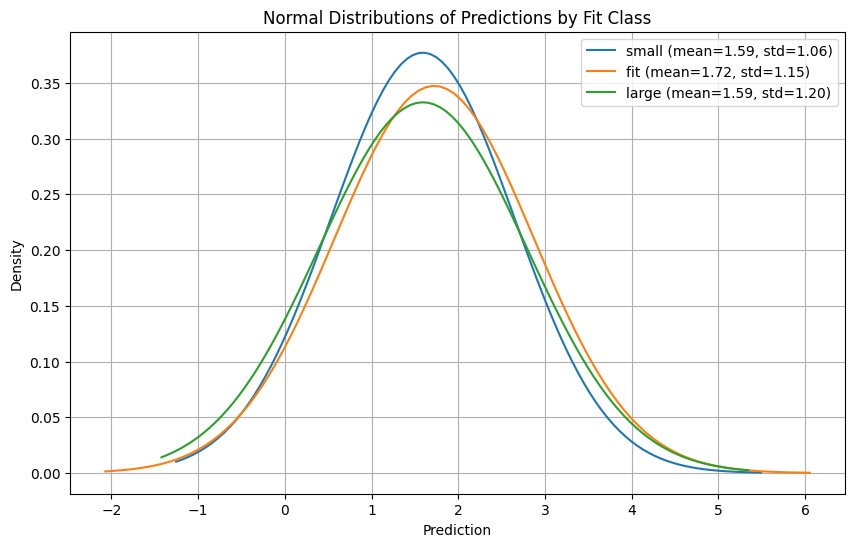

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plot the normal distributions for each fit_class
plt.figure(figsize=(10, 6))

for fit_class, predictions in predictions_by_class.items():
    # Fit a normal distribution to the predictions
    mean, std = norm.fit(predictions)

    # Generate x values for the distribution
    x = np.linspace(min(predictions), max(predictions), 100)
    pdf = norm.pdf(x, mean, std)  # Probability density function

    # Plot the normal distribution
    plt.plot(x, pdf, label=f'{fit_class} (mean={mean:.2f}, std={std:.2f})')

# Add plot details
plt.title('Normal Distributions of Predictions by Fit Class')
plt.xlabel('Prediction')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()


In [91]:
# Create lists to store predictions and true labels
true_labels = []
predicted_labels = []

# Create a dictionary to store predictions by class
predictions_by_class_test = {}

# Loop through the interactions
for u, i in interactionsTest[:30000]:
    # Generate the prediction
    prediction = modelBPR.predict(userIDs[u], itemIDs[i]).numpy()

    # Classify the prediction
    prediction_class = 1 if prediction < 4 else 0  # 1 for fit, 0 for small/large
    predicted_labels.append(prediction_class)

    # Extract the true label (1 for fit, 0 for small/large)
    fit_class = cleaned_df.loc[(cleaned_df['user_id'] == u) & (cleaned_df['item_id'] == i), 'fit'].values[0]

    # Initialize the list for this fit_class in predictions_by_class_test if not already present
    if fit_class not in predictions_by_class_test:
        predictions_by_class_test[fit_class] = []

    # Append the prediction to the corresponding class
    predictions_by_class_test[fit_class].append(prediction)

    # Convert fit_class to a numerical true_label
    true_label = 1 if fit_class == 'fit' else 0
    true_labels.append(true_label)

# Calculate accuracy
from sklearn.metrics import accuracy_score, fbeta_score

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2%}")

unbalanced_f2_score = fbeta_score(true_labels, predicted_labels, beta=2)
print(f"F-Beta Score (beta=2) Unbalanced Data: {unbalanced_f2_score:.2%}")

Accuracy: 35.32%
F-Beta Score (beta=0.5) Unbalanced Data: 72.07%


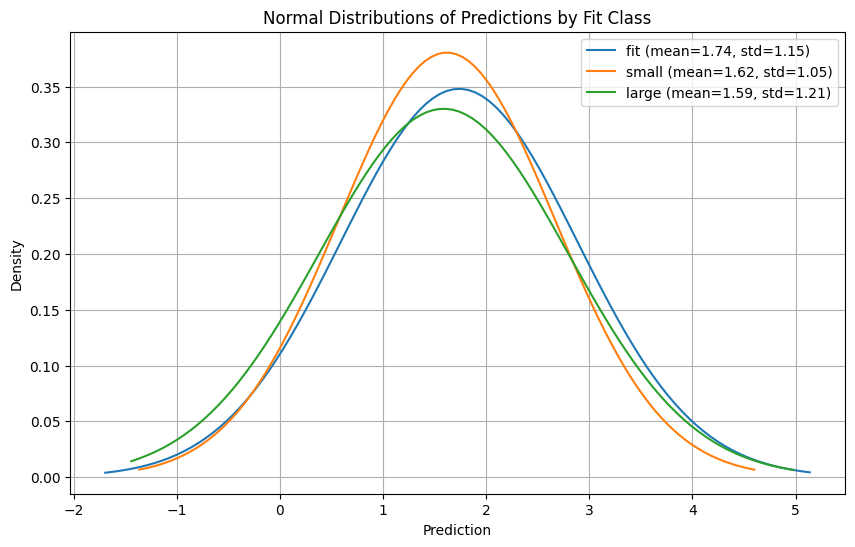

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plot the normal distributions for each fit_class
plt.figure(figsize=(10, 6))

for fit_class, predictions in predictions_by_class_test.items():
    # Fit a normal distribution to the predictions
    mean, std = norm.fit(predictions)

    # Generate x values for the distribution
    x = np.linspace(min(predictions), max(predictions), 100)
    pdf = norm.pdf(x, mean, std)  # Probability density function

    # Plot the normal distribution
    plt.plot(x, pdf, label=f'{fit_class} (mean={mean:.2f}, std={std:.2f})')

# Add plot details
plt.title('Normal Distributions of Predictions by Fit Class')
plt.xlabel('Prediction')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()


In [41]:
#undersampled code

In [42]:
##### Ablation study about sample the fit label to make fit, small, large labels evenly distibuted.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Function to undersample the 'fit' category
def undersample(df):
    # Find the number of samples in the smallest class
    min_class_size = min(df['fit'].value_counts())

    # Sample from each category
    fit_sample = df[df['fit'] == 'fit'].sample(min_class_size, random_state=random_seed)
    small_sample = df[df['fit'] == 'small']
    large_sample = df[df['fit'] == 'large']

    # Combine the samples into a new dataframe
    undersampled_df = pd.concat([fit_sample, small_sample, large_sample]).sample(frac=1, random_state=random_seed)  # Shuffle the dataset
    return undersampled_df

undersampled_df = undersample(cleaned_df)

# Display the shapes of the resulting datasets
print(f"Undersampled dataset shape: {cleaned_df.shape}")

# Distribution of labels (fit, small, large) in the datasets
train_label_distribution = train_df['fit'].value_counts(normalize=True) * 100  # Percentage distribution
validate_label_distribution = validate_df['fit'].value_counts(normalize=True) * 100
test_label_distribution = test_df['fit'].value_counts(normalize=True) * 100

# Create a summary table for label distribution
label_distribution_summary = pd.DataFrame({
    'Train (%)': train_label_distribution,
    'Validate (%)': validate_label_distribution,
    'Test (%)': test_label_distribution
}).fillna(0)  # Fill missing labels with 0

# Display the distribution summary
print("Label Distribution Summary:")
print(label_distribution_summary)

# Ensure 'fit' column is encoded for classification tasks
label_encoder = LabelEncoder()
train_df['fit_encoded'] = label_encoder.fit_transform(train_df['fit'])
validate_df['fit_encoded'] = label_encoder.transform(validate_df['fit'])
test_df['fit_encoded'] = label_encoder.transform(test_df['fit'])

Undersampled dataset shape: (135498, 21)
Label Distribution Summary:
       Train (%)  Validate (%)   Test (%)
fit                                      
fit    73.633603     73.638376  73.510455
small  13.297065     13.264453  13.608856
large  13.069332     13.097171  12.880689


In [43]:
undersampled_df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,...,height,size,age,review_date,band_size,cup_size,weight_numeric,height_inches,body_type_encoded,rented_for_encoded
19381,small,537954,34b,166633,110lbs,10.0,date,The only thing I wish I had known was how thic...,petite,I wore this for my birthday dinner - it was a ...,...,"5' 5""",4,31.0,"November 3, 2014",34.0,2.0,110.0,65,5,4
82392,large,479861,34b,1630965,150lbs,10.0,formal affair,Perfect,pear,"Beautiful, classic dress.",...,"5' 6""",8,35.0,"December 28, 2016",34.0,2.0,150.0,66,2,2
32158,large,638029,34c,154652,135lbs,4.0,party,I got this dress for a bachelorette party in v...,hourglass,Runs so large,...,"5' 7""",8,30.0,"June 3, 2012",34.0,3.0,135.0,67,0,6
122293,small,49328,32b,2196467,121lbs,8.0,work,"I am usually a small, size 2 or 4. This skirt ...",straight & narrow,Ran very very small.,...,"5' 10""",14,37.0,"November 8, 2016",32.0,2.0,121.0,70,1,7
56794,small,415019,36c,782051,150lbs,6.0,wedding,The bottom of the dress was very heavy and bulky.,hourglass,I loved the color.,...,"5' 6""",20,39.0,"September 7, 2017",36.0,3.0,150.0,66,0,3


In [44]:
userIDs = {}
itemIDs = {}

interactions = []
# positive_interactions = []
for _, row in  undersampled_df[['user_id', 'item_id']].iterrows():
    interactions.append([row['user_id'], row['item_id']])

In [45]:
interactions

[[537954, 166633],
 [479861, 1630965],
 [638029, 154652],
 [49328, 2196467],
 [415019, 782051],
 [106594, 1567172],
 [171664, 2402529],
 [550764, 141688],
 [575016, 1730006],
 [737756, 1687910],
 [149052, 729362],
 [833675, 1667930],
 [546851, 1241917],
 [323466, 145417],
 [664997, 1518052],
 [208982, 154002],
 [655911, 1494967],
 [552596, 1459539],
 [822386, 1756705],
 [64887, 178058],
 [163107, 137585],
 [555327, 279859],
 [263302, 496108],
 [741965, 206536],
 [839769, 1125699],
 [344217, 2955585],
 [773497, 2418539],
 [119076, 1832871],
 [487545, 2902058],
 [765119, 137585],
 [695143, 1924050],
 [433279, 561264],
 [602302, 2270513],
 [434812, 1261393],
 [286128, 180843],
 [791917, 192258],
 [152238, 323450],
 [949207, 1934641],
 [673753, 1800440],
 [625736, 800975],
 [408409, 1278888],
 [566132, 1108814],
 [524176, 703458],
 [441940, 716777],
 [173376, 1584972],
 [755627, 149655],
 [45387, 478077],
 [934710, 693849],
 [714469, 1134208],
 [808969, 579746],
 [159488, 439655],
 [619027

In [46]:
def map_ids(interactions):
    userIDs = {}
    itemIDs = {}
    mapped_interactions = []
    for u, b in interactions:
        if u not in userIDs:
            userIDs[u] = len(userIDs)
        if b not in itemIDs:
            itemIDs[b] = len(itemIDs)
        mapped_interactions.append((userIDs[u], itemIDs[b]))

    return userIDs, itemIDs, mapped_interactions

In [47]:
import random
from collections import defaultdict

random.shuffle(interactions)
print(len(interactions))
nTrain = int(len(interactions) * 0.9)
nTest = len(interactions) - nTrain
interactionsTrain = interactions[:nTrain]
interactionsTest = interactions[nTrain:]



53426


In [48]:
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
for u,i in interactionsTrain:
    itemsPerUser[u].append(i)
    usersPerItem[i].append(u)

In [49]:
userIDs, itemIDs, mapped_interactions = map_ids(interactions=interactions)

In [50]:
mapped_interactions

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 2),
 (9, 8),
 (10, 9),
 (11, 10),
 (12, 11),
 (13, 12),
 (14, 13),
 (15, 14),
 (16, 15),
 (17, 16),
 (18, 17),
 (19, 18),
 (20, 19),
 (21, 20),
 (22, 21),
 (23, 22),
 (24, 23),
 (25, 24),
 (26, 18),
 (27, 25),
 (28, 26),
 (29, 27),
 (30, 28),
 (31, 29),
 (32, 30),
 (33, 31),
 (34, 32),
 (35, 33),
 (36, 34),
 (37, 35),
 (38, 36),
 (39, 37),
 (40, 38),
 (41, 39),
 (42, 40),
 (43, 41),
 (44, 42),
 (45, 43),
 (46, 44),
 (47, 18),
 (48, 45),
 (49, 46),
 (50, 47),
 (51, 48),
 (52, 49),
 (53, 50),
 (54, 51),
 (55, 52),
 (56, 53),
 (57, 54),
 (58, 55),
 (59, 56),
 (60, 57),
 (61, 58),
 (62, 59),
 (63, 60),
 (64, 61),
 (65, 62),
 (66, 63),
 (67, 64),
 (68, 65),
 (69, 66),
 (70, 67),
 (71, 68),
 (72, 15),
 (73, 69),
 (74, 70),
 (75, 71),
 (76, 72),
 (77, 73),
 (78, 74),
 (79, 75),
 (80, 76),
 (81, 77),
 (82, 78),
 (83, 79),
 (84, 80),
 (85, 81),
 (86, 82),
 (87, 83),
 (88, 84),
 (89, 85),
 (90, 86),
 (91, 44),
 (92, 87)

In [51]:
len(itemIDs)

5056

In [52]:
items = list(range(len(itemIDs)))

class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super(BPRbatch, self).__init__()
        # Initialize variables
        self.lamb = lamb
        self.K = K

        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        # Regularization coefficient

    # Prediction for a single instance
    def predict(self, u, i):
        p = self.betaI[i] + tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaU) +\
                            tf.nn.l2_loss(self.gammaI))

    def score(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        x_ui = beta_i + tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return x_ui

    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_ui - x_uj)))

In [53]:
optimizer = tf.keras.optimizers.Adam(0.1)

In [54]:
modelBPR = BPRbatch(3, 0.00001)

In [55]:
interactions

[[614722, 136860],
 [254319, 1330312],
 [199884, 126335],
 [730048, 561215],
 [964232, 132738],
 [633181, 1181917],
 [413115, 136110],
 [214703, 2529948],
 [239220, 126335],
 [628450, 124204],
 [432178, 721424],
 [840347, 1832896],
 [555916, 2027980],
 [470486, 467091],
 [990221, 883661],
 [670138, 499679],
 [280317, 148089],
 [506712, 1698166],
 [955414, 1074283],
 [942043, 145906],
 [392673, 892222],
 [764513, 588814],
 [674254, 1108814],
 [373817, 1463543],
 [868728, 832622],
 [123819, 903091],
 [758448, 145906],
 [725296, 1176070],
 [721271, 1031440],
 [369603, 131117],
 [456520, 642677],
 [673278, 1232187],
 [46566, 2599988],
 [963001, 2135183],
 [247355, 1142945],
 [912367, 172027],
 [12633, 1057664],
 [94413, 127081],
 [691468, 1013498],
 [136428, 755371],
 [452273, 756020],
 [580776, 2683802],
 [399244, 533452],
 [35561, 192258],
 [378553, 724319],
 [163460, 168610],
 [891034, 125564],
 [617670, 145906],
 [300500, 149739],
 [257715, 865225],
 [38858, 1313746],
 [870263, 144585]

In [56]:
def trainingStepBPR(model, mapped_interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ = [], [], []
        for _ in range(Nsamples):
            u,i = random.choice(mapped_interactions) # positive sample
            j = random.choice(items) # negative sample
            while j in itemsPerUser[u]:
                j = random.choice(items)
            sampleU.append(u)
            sampleI.append(i)
            sampleJ.append(j)

        sampleU_arr = np.array(sampleU, dtype=np.int32)
        sampleI_arr = np.array(sampleI, dtype=np.int32)
        sampleJ_arr = np.array(sampleJ, dtype=np.int32)

        # print(sampleU, sampleI, sampleJ)
        loss = model(sampleU_arr,sampleI_arr,sampleJ_arr)
        loss += model.reg()

    # print(model.trainable_variables)
    gradients = tape.gradient(loss, model.trainable_variables)
    # print(gradients)

    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [57]:
for i in range(100):
    obj = trainingStepBPR(modelBPR, mapped_interactions)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 0.48255628
iteration 20, objective = 0.41084698
iteration 30, objective = 0.39239168
iteration 40, objective = 0.3836348
iteration 50, objective = 0.376338
iteration 60, objective = 0.3726459
iteration 70, objective = 0.36925483
iteration 80, objective = 0.3667028
iteration 90, objective = 0.36457348
iteration 100, objective = 0.36295444


In [58]:
u,i = interactionsTest[0]

In [59]:
modelBPR.predict(userIDs[u], itemIDs[i]).numpy()

2.8223581

In [60]:
# Create a dictionary to store predictions for each fit_class
predictions_by_class = {}

# Loop through the interactions
for u, i in interactionsTrain[:30000]:
    # Generate the prediction
    prediction = modelBPR.predict(userIDs[u], itemIDs[i]).numpy()

    # Extract the fit_class for this user-item pair
    fit_class = cleaned_df.loc[(cleaned_df['user_id'] == u) & (cleaned_df['item_id'] == i), 'fit'].values[0]

    # Initialize the list for this fit_class if not already present
    if fit_class not in predictions_by_class:
        predictions_by_class[fit_class] = []

    # Append the prediction to the corresponding fit_class list
    predictions_by_class[fit_class].append(prediction)

# Now, predictions_by_class is a dictionary where keys are fit classes and values are lists of predictions


In [61]:
len(predictions_by_class['small'])+len(predictions_by_class['fit'])+len(predictions_by_class['large'])

30000

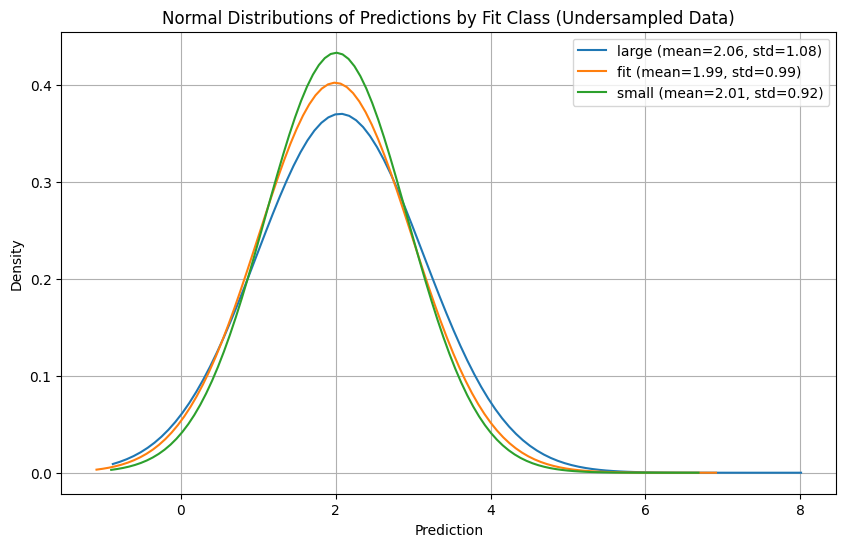

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plot the normal distributions for each fit_class
plt.figure(figsize=(10, 6))

for fit_class, predictions in predictions_by_class.items():
    # Fit a normal distribution to the predictions
    mean, std = norm.fit(predictions)

    # Generate x values for the distribution
    x = np.linspace(min(predictions), max(predictions), 100)
    pdf = norm.pdf(x, mean, std)  # Probability density function

    # Plot the normal distribution
    plt.plot(x, pdf, label=f'{fit_class} (mean={mean:.2f}, std={std:.2f})')

# Add plot details
plt.title('Normal Distributions of Predictions by Fit Class (Undersampled Data)')
plt.xlabel('Prediction')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()


In [63]:
# Create lists to store predictions and true labels
true_labels = []
predicted_labels = []

# Create a dictionary to store predictions by class
predictions_by_class_test = {}

# Loop through the interactions
for u, i in interactionsTest[:30000]:
    # Generate the prediction
    prediction = modelBPR.predict(userIDs[u], itemIDs[i]).numpy()

    # Classify the prediction
    prediction_class = 1 if prediction < 4 else 0  # 1 for fit, 0 for small/large
    predicted_labels.append(prediction_class)

    # Extract the true label (1 for fit, 0 for small/large)
    fit_class = cleaned_df.loc[(cleaned_df['user_id'] == u) & (cleaned_df['item_id'] == i), 'fit'].values[0]

    # Initialize the list for this fit_class in predictions_by_class_test if not already present
    if fit_class not in predictions_by_class_test:
        predictions_by_class_test[fit_class] = []

    # Append the prediction to the corresponding class
    predictions_by_class_test[fit_class].append(prediction)

    # Convert fit_class to a numerical true_label
    true_label = 1 if fit_class == 'fit' else 0
    true_labels.append(true_label)

# Calculate accuracy
from sklearn.metrics import accuracy_score, fbeta_score

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2%}")

undersampled_f2_score = fbeta_score(true_labels, predicted_labels, beta=2)
print(f"F2 Score (Undersampled-data): {undersampled_f2_score:.2f}")

Accuracy: 33.37%
F2 Score (Undersampled-data): 0.70


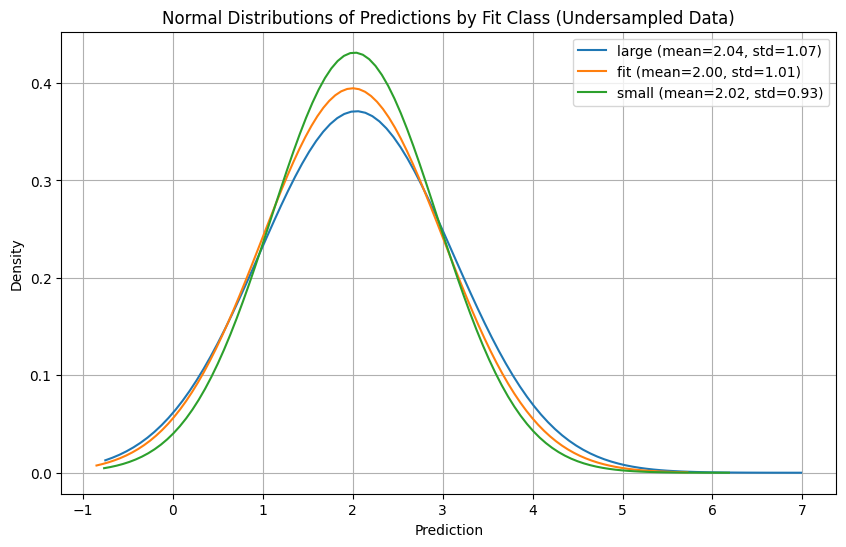

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plot the normal distributions for each fit_class
plt.figure(figsize=(10, 6))

for fit_class, predictions in predictions_by_class_test.items():
    # Fit a normal distribution to the predictions
    mean, std = norm.fit(predictions)

    # Generate x values for the distribution
    x = np.linspace(min(predictions), max(predictions), 100)
    pdf = norm.pdf(x, mean, std)  # Probability density function

    # Plot the normal distribution
    plt.plot(x, pdf, label=f'{fit_class} (mean={mean:.2f}, std={std:.2f})')

# Add plot details
plt.title('Normal Distributions of Predictions by Fit Class (Undersampled Data)')
plt.xlabel('Prediction')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()


In [65]:
#Oversampling code

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample



# Function to oversample the 'small' and 'large' categories
def oversample(df):
    # Find the number of samples in the largest class
    max_class_size = df['fit'].value_counts().max()

    # Resample 'small' and 'large' categories
    fit_sample = df[df['fit'] == 'fit']
    small_sample = resample(df[df['fit'] == 'small'], replace=True, n_samples=max_class_size, random_state=random_seed)
    large_sample = resample(df[df['fit'] == 'large'], replace=True, n_samples=max_class_size, random_state=random_seed)

    # Combine the samples into a new dataframe
    oversampled_df = pd.concat([fit_sample, small_sample, large_sample]).sample(frac=1, random_state=random_seed)  # Shuffle the dataset
    return oversampled_df

oversampled_df = oversample(cleaned_df)

# Display the shapes of the resulting datasets
print(f"Train dataset shape: {train_df.shape}")
print(f"Validate dataset shape: {validate_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

# Distribution of labels (fit, small, large) in the datasets
train_label_distribution = train_df['fit'].value_counts(normalize=True) * 100  # Percentage distribution
validate_label_distribution = validate_df['fit'].value_counts(normalize=True) * 100
test_label_distribution = test_df['fit'].value_counts(normalize=True) * 100

# Create a summary table for label distribution
label_distribution_summary = pd.DataFrame({
    'Train (%)': train_label_distribution,
    'Validate (%)': validate_label_distribution,
    'Test (%)': test_label_distribution
}).fillna(0)  # Fill missing labels with 0

# Display the distribution summary
print("Label Distribution Summary:")
print(label_distribution_summary)

# Ensure 'fit' column is encoded for classification tasks
label_encoder = LabelEncoder()
train_df['fit_encoded'] = label_encoder.fit_transform(train_df['fit'])
validate_df['fit_encoded'] = label_encoder.transform(validate_df['fit'])
test_df['fit_encoded'] = label_encoder.transform(test_df['fit'])


Train dataset shape: (94848, 22)
Validate dataset shape: (20325, 22)
Test dataset shape: (20325, 22)
Label Distribution Summary:
       Train (%)  Validate (%)   Test (%)
fit                                      
fit    73.633603     73.638376  73.510455
small  13.297065     13.264453  13.608856
large  13.069332     13.097171  12.880689


In [67]:
oversampled_df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,...,height,size,age,review_date,band_size,cup_size,weight_numeric,height_inches,body_type_encoded,rented_for_encoded
15131,small,266982,34b,1260666,117lbs,10.0,vacation,The Small was a perfect fit for me. My other ...,hourglass,This dress was a real showstopper. I have nev...,...,"5' 4""",8,33.0,"September 6, 2016",34.0,2.0,117.0,64,0,0
56118,large,979762,36c,153475,168lbs,8.0,formal affair,"The fit overall was great, the bust area was ...",pear,OMG RTR made my day the fit of the gown was pe...,...,"5' 9""",25,47.0,"November 12, 2013",36.0,3.0,168.0,69,2,2
151494,large,399600,34d,2645343,112lbs,8.0,everyday,I was SO excited to rent this jacket as I love...,hourglass,Very large on a petite frame,...,"5' 3""",4,33.0,"March 6, 2016",34.0,4.0,112.0,63,0,5
53452,large,252690,34c,2260645,135lbs,8.0,everyday,This top was very comfortable. It has a sligh...,pear,Team RTR Review,...,"5' 4""",14,33.0,"October 23, 2017",34.0,3.0,135.0,64,2,5
180782,large,818223,34b,1510143,150lbs,6.0,formal affair,This dress is HUGE! I get that it's supposed t...,athletic,Not made for athletic girls,...,"5' 6""",4,35.0,"July 3, 2017",34.0,2.0,150.0,66,3,2


In [68]:
userIDs = {}
itemIDs = {}

interactions = []
# positive_interactions = []
for _, row in  oversampled_df[['user_id', 'item_id']].iterrows():
    interactions.append([row['user_id'], row['item_id']])

In [69]:
interactions

[[266982, 1260666],
 [979762, 153475],
 [399600, 2645343],
 [252690, 2260645],
 [818223, 1510143],
 [223717, 1018841],
 [48878, 136860],
 [12633, 1057664],
 [692364, 1560875],
 [685438, 145906],
 [495160, 1027436],
 [178831, 1738544],
 [387681, 127865],
 [968111, 480832],
 [184289, 591853],
 [862566, 130259],
 [722893, 1987884],
 [432024, 864981],
 [525501, 169961],
 [851957, 1754771],
 [564831, 1029668],
 [282490, 1145592],
 [280157, 181453],
 [408552, 2163773],
 [677214, 1875147],
 [782298, 1922958],
 [192312, 797218],
 [254759, 965888],
 [897223, 1156321],
 [488604, 1955352],
 [41481, 979046],
 [703838, 2553766],
 [973422, 2028346],
 [893791, 125424],
 [17089, 134015],
 [919173, 755371],
 [591113, 1626903],
 [819042, 259934],
 [786816, 1925838],
 [651391, 1883531],
 [947774, 2239701],
 [829166, 155735],
 [380408, 1857455],
 [569806, 1396878],
 [233246, 164051],
 [267911, 154002],
 [76220, 655775],
 [909087, 1950621],
 [804585, 159395],
 [256499, 140321],
 [850040, 326908],
 [759737,

In [70]:
def map_ids(interactions):
    userIDs = {}
    itemIDs = {}
    mapped_interactions = []
    for u, b in interactions:
        if u not in userIDs:
            userIDs[u] = len(userIDs)
        if b not in itemIDs:
            itemIDs[b] = len(itemIDs)
        mapped_interactions.append((userIDs[u], itemIDs[b]))

    return userIDs, itemIDs, mapped_interactions

In [71]:
random.shuffle(interactions)
print(len(interactions))
nTrain = int(len(interactions) * 0.9)
nTest = len(interactions) - nTrain
interactionsTrain = interactions[:nTrain]
interactionsTest = interactions[nTrain:]

299244


In [72]:
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
for u,i in interactionsTrain:
    itemsPerUser[u].append(i)
    usersPerItem[i].append(u)

In [73]:
userIDs, itemIDs, mapped_interactions = map_ids(interactions=interactions)

In [74]:
mapped_interactions

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 9),
 (15, 14),
 (16, 15),
 (17, 16),
 (18, 17),
 (19, 18),
 (20, 19),
 (21, 20),
 (22, 21),
 (23, 22),
 (24, 23),
 (25, 24),
 (26, 25),
 (27, 26),
 (28, 27),
 (29, 28),
 (30, 29),
 (31, 30),
 (32, 31),
 (33, 32),
 (34, 33),
 (35, 34),
 (36, 35),
 (37, 36),
 (38, 37),
 (39, 38),
 (40, 39),
 (41, 40),
 (42, 41),
 (43, 42),
 (44, 43),
 (45, 44),
 (46, 45),
 (47, 46),
 (48, 47),
 (49, 48),
 (50, 49),
 (51, 50),
 (52, 51),
 (53, 52),
 (54, 19),
 (55, 53),
 (56, 54),
 (57, 55),
 (58, 56),
 (59, 57),
 (60, 58),
 (61, 59),
 (62, 60),
 (63, 8),
 (64, 34),
 (65, 28),
 (66, 61),
 (67, 62),
 (68, 63),
 (69, 64),
 (70, 65),
 (71, 66),
 (72, 67),
 (73, 68),
 (74, 69),
 (75, 70),
 (76, 71),
 (77, 72),
 (78, 73),
 (79, 74),
 (80, 75),
 (81, 76),
 (82, 77),
 (83, 78),
 (84, 79),
 (85, 80),
 (86, 8),
 (87, 81),
 (88, 82),
 (89, 83),
 (90, 84),
 (91, 85),
 (92, 86),


In [75]:
len(itemIDs)

5667

In [76]:
items = list(range(len(itemIDs)))

class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super(BPRbatch, self).__init__()
        # Initialize variables
        self.lamb = lamb
        self.K = K

        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        # Regularization coefficient

    # Prediction for a single instance
    def predict(self, u, i):
        p = self.betaI[i] + tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaU) +\
                            tf.nn.l2_loss(self.gammaI))

    def score(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        x_ui = beta_i + tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return x_ui

    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_ui - x_uj)))

In [77]:
optimizer = tf.keras.optimizers.Adam(0.1)

In [78]:
modelBPR = BPRbatch(3, 0.00001)

In [79]:
interactions

[[753325, 1076484],
 [619345, 721403],
 [824022, 1142945],
 [759825, 1283795],
 [366550, 1547971],
 [405413, 859692],
 [633928, 1505709],
 [93995, 123793],
 [89875, 132738],
 [709589, 127865],
 [643590, 1460767],
 [48287, 1480010],
 [820547, 1269149],
 [633575, 312893],
 [929914, 127865],
 [910579, 2468077],
 [252311, 1754708],
 [231638, 135750],
 [362965, 178527],
 [232385, 145906],
 [252056, 2845075],
 [252908, 129831],
 [360402, 527130],
 [257215, 2419758],
 [451234, 296430],
 [132196, 2536470],
 [913091, 369203],
 [630404, 125424],
 [794957, 183200],
 [656513, 126335],
 [445743, 144051],
 [472209, 493510],
 [456278, 166633],
 [216072, 2954118],
 [711214, 168610],
 [772957, 172027],
 [530487, 351928],
 [140042, 1679360],
 [301048, 1210991],
 [707200, 2490518],
 [466566, 1749401],
 [582161, 948805],
 [94068, 1860491],
 [641437, 432268],
 [548789, 1045604],
 [4232, 187164],
 [525604, 344292],
 [338389, 1678888],
 [167871, 168592],
 [925642, 150138],
 [317927, 2916025],
 [979034, 14635

In [80]:
userIDs

{753325: 0,
 619345: 1,
 824022: 2,
 759825: 3,
 366550: 4,
 405413: 5,
 633928: 6,
 93995: 7,
 89875: 8,
 709589: 9,
 643590: 10,
 48287: 11,
 820547: 12,
 633575: 13,
 929914: 14,
 910579: 15,
 252311: 16,
 231638: 17,
 362965: 18,
 232385: 19,
 252056: 20,
 252908: 21,
 360402: 22,
 257215: 23,
 451234: 24,
 132196: 25,
 913091: 26,
 630404: 27,
 794957: 28,
 656513: 29,
 445743: 30,
 472209: 31,
 456278: 32,
 216072: 33,
 711214: 34,
 772957: 35,
 530487: 36,
 140042: 37,
 301048: 38,
 707200: 39,
 466566: 40,
 582161: 41,
 94068: 42,
 641437: 43,
 548789: 44,
 4232: 45,
 525604: 46,
 338389: 47,
 167871: 48,
 925642: 49,
 317927: 50,
 979034: 51,
 319965: 52,
 359607: 53,
 869839: 54,
 413039: 55,
 31832: 56,
 928283: 57,
 908171: 58,
 927844: 59,
 395515: 60,
 726494: 61,
 56660: 62,
 993380: 63,
 101903: 64,
 291298: 65,
 251075: 66,
 820493: 67,
 572355: 68,
 218780: 69,
 637186: 70,
 995541: 71,
 101564: 72,
 293159: 73,
 763030: 74,
 758412: 75,
 18185: 76,
 877451: 77,
 7405

In [81]:
def trainingStepBPR(model, mapped_interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ = [], [], []
        for _ in range(Nsamples):
            u,i = random.choice(mapped_interactions) # positive sample
            j = random.choice(items) # negative sample
            while j in itemsPerUser[u]:
                j = random.choice(items)
            sampleU.append(u)
            sampleI.append(i)
            sampleJ.append(j)

        sampleU_arr = np.array(sampleU, dtype=np.int32)
        sampleI_arr = np.array(sampleI, dtype=np.int32)
        sampleJ_arr = np.array(sampleJ, dtype=np.int32)

        # print(sampleU, sampleI, sampleJ)
        loss = model(sampleU_arr,sampleI_arr,sampleJ_arr)
        loss += model.reg()

    # print(model.trainable_variables)
    gradients = tape.gradient(loss, model.trainable_variables)
    # print(gradients)

    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [82]:
for i in range(100):
    obj = trainingStepBPR(modelBPR, mapped_interactions)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 0.46477062
iteration 20, objective = 0.41140258
iteration 30, objective = 0.39887136
iteration 40, objective = 0.39363915
iteration 50, objective = 0.3885737
iteration 60, objective = 0.3848219
iteration 70, objective = 0.3802078
iteration 80, objective = 0.37997943
iteration 90, objective = 0.3729461
iteration 100, objective = 0.3716706


In [83]:
u,i = interactionsTest[0]

In [84]:
modelBPR.predict(userIDs[u], itemIDs[i]).numpy()

0.71653855

In [85]:
# Create a dictionary to store predictions for each fit_class
predictions_by_class = {}

# Loop through the interactions
for u, i in interactionsTrain[:30000]:
    # Generate the prediction
    prediction = modelBPR.predict(userIDs[u], itemIDs[i]).numpy()

    # Extract the fit_class for this user-item pair
    fit_class = cleaned_df.loc[(cleaned_df['user_id'] == u) & (cleaned_df['item_id'] == i), 'fit'].values[0]

    # Initialize the list for this fit_class if not already present
    if fit_class not in predictions_by_class:
        predictions_by_class[fit_class] = []

    # Append the prediction to the corresponding fit_class list
    predictions_by_class[fit_class].append(prediction)

# Now, predictions_by_class is a dictionary where keys are fit classes and values are lists of predictions


In [86]:
len(predictions_by_class['small'])+len(predictions_by_class['fit'])+len(predictions_by_class['large'])

30000

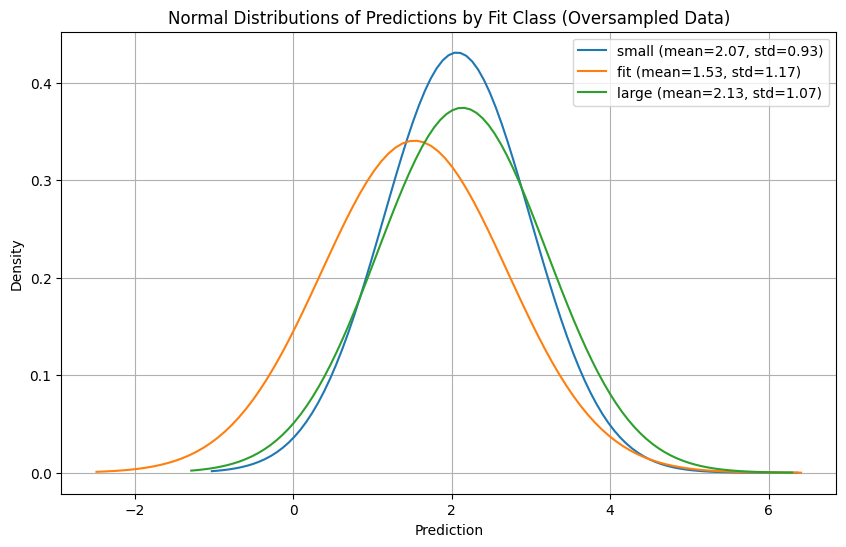

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plot the normal distributions for each fit_class
plt.figure(figsize=(10, 6))

for fit_class, predictions in predictions_by_class.items():
    # Fit a normal distribution to the predictions
    mean, std = norm.fit(predictions)

    # Generate x values for the distribution
    x = np.linspace(min(predictions), max(predictions), 100)
    pdf = norm.pdf(x, mean, std)  # Probability density function

    # Plot the normal distribution
    plt.plot(x, pdf, label=f'{fit_class} (mean={mean:.2f}, std={std:.2f})')

# Add plot details
plt.title('Normal Distributions of Predictions by Fit Class (Oversampled Data)')
plt.xlabel('Prediction')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()


In [90]:
# Create lists to store predictions and true labels
true_labels = []
predicted_labels = []

# Create a dictionary to store predictions by class
predictions_by_class_test = {}

# Loop through the interactions
for u, i in interactionsTest[:30000]:
    # Generate the prediction
    prediction = modelBPR.predict(userIDs[u], itemIDs[i]).numpy()

    # Classify the prediction
    prediction_class = 1 if prediction < 3 else 0  # 1 for fit, 0 for small/large
    predicted_labels.append(prediction_class)

    # Extract the true label (1 for fit, 0 for small/large)
    fit_class = cleaned_df.loc[(cleaned_df['user_id'] == u) & (cleaned_df['item_id'] == i), 'fit'].values[0]

    # Initialize the list for this fit_class in predictions_by_class_test if not already present
    if fit_class not in predictions_by_class_test:
        predictions_by_class_test[fit_class] = []

    # Append the prediction to the corresponding class
    predictions_by_class_test[fit_class].append(prediction)

    # Convert fit_class to a numerical true_label
    true_label = 1 if fit_class == 'fit' else 0
    true_labels.append(true_label)

# Calculate accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy (Oversampled-data): {accuracy:.2%}")

# Calculate F2 score
oversampled_f2_score = fbeta_score(true_labels, predicted_labels, beta=2)
print(f"F2 Score (Oversampled-data): {oversampled_f2_score:.2f}")

Accuracy (Oversampled-data): 42.67%
F2 Score (Oversampled-data): 0.68


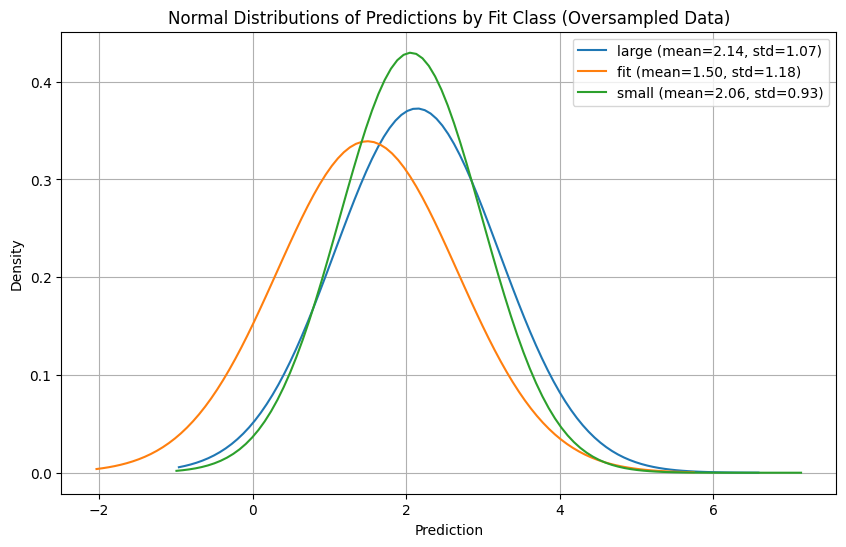

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plot the normal distributions for each fit_class
plt.figure(figsize=(10, 6))

for fit_class, predictions in predictions_by_class_test.items():
    # Fit a normal distribution to the predictions
    mean, std = norm.fit(predictions)

    # Generate x values for the distribution
    x = np.linspace(min(predictions), max(predictions), 100)
    pdf = norm.pdf(x, mean, std)  # Probability density function

    # Plot the normal distribution
    plt.plot(x, pdf, label=f'{fit_class} (mean={mean:.2f}, std={std:.2f})')

# Add plot details
plt.title('Normal Distributions of Predictions by Fit Class (Oversampled Data)')
plt.xlabel('Prediction')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()
